In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("/home1/smaruj/akitaV2-analyses/figures/plot_styles/global_plotting_style.mplstyle")
from scipy.stats import chisquare

from helper import (read_and_average_virtual_exp,
                    load_top_bottom_sequences,
                    calculate_gc_content_at_positions,
                    process_sequences,
                    generate_kmers,
                    count_kmers_total)

# GC Content

In [2]:
paths = {
    "top": "./fasta_files/150_top_insertion_30bp_flanks.fasta",
    "bottom": "./fasta_files/150_bottom_insertion_30bp_flanks.fasta"
}

# Load sequences
sequences = {key: load_top_bottom_sequences(path) for key, path in paths.items()}

# Access sequences
whole_top, upstream_top, downstream_top = sequences["top"]
whole_bottom, upstream_bottom, downstream_bottom = sequences["bottom"]

### GC Content - Core + 30bp Flanks

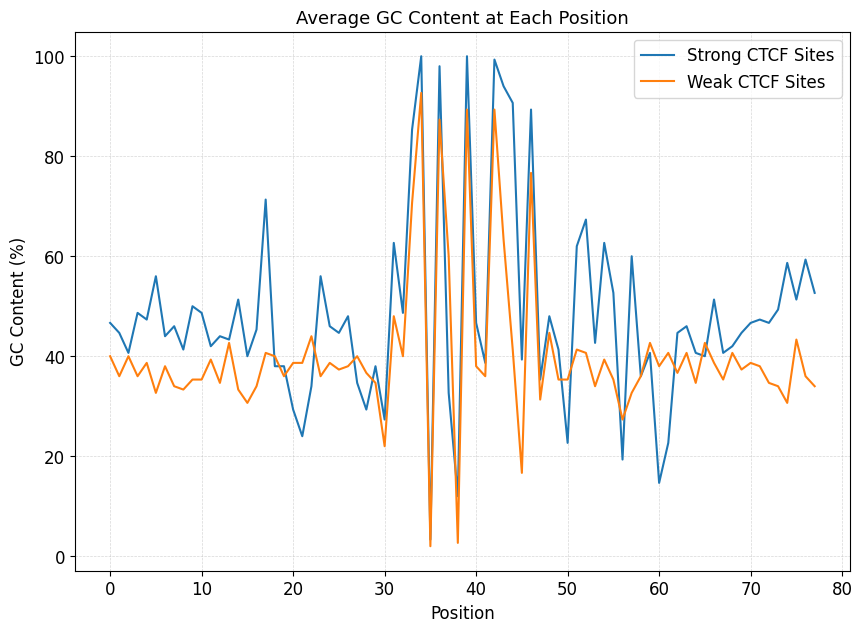

In [3]:
plt.figure(figsize=(10, 7))
plt.plot(calculate_gc_content_at_positions(whole_top), label='Strong CTCF Sites')
plt.plot(calculate_gc_content_at_positions(whole_bottom), label='Weak CTCF Sites')
plt.xlabel('Position')
plt.ylabel('GC Content (%)')
plt.title('Average GC Content at Each Position')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
# plt.savefig("./plots/GC_content_strong_vs_weak.pdf", format="pdf", bbox_inches="tight")
plt.show()

### GC Content - Upstream Flank

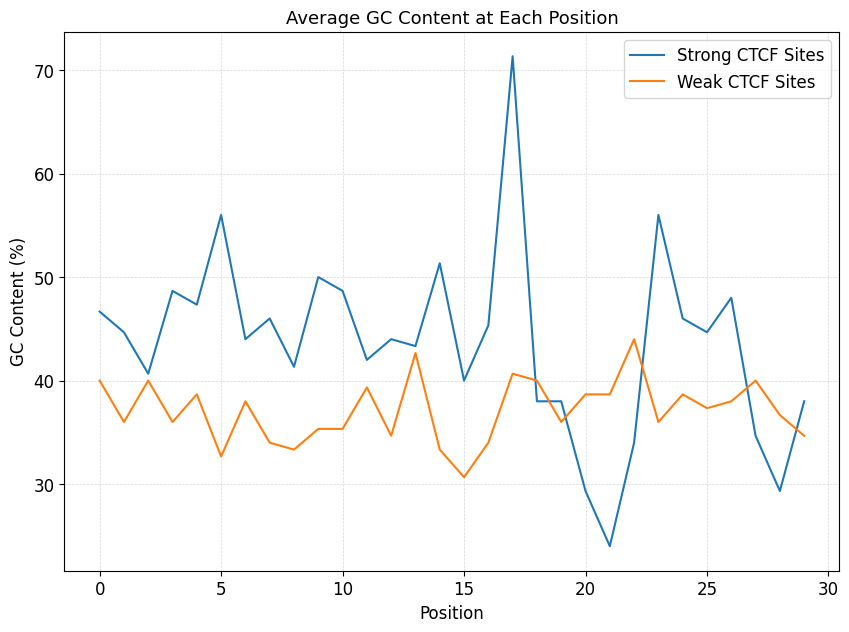

In [4]:
plt.figure(figsize=(10, 7))
plt.plot(calculate_gc_content_at_positions(upstream_top), label='Strong CTCF Sites')
plt.plot(calculate_gc_content_at_positions(upstream_bottom), label='Weak CTCF Sites')
plt.xlabel('Position')
plt.ylabel('GC Content (%)')
plt.title('Average GC Content at Each Position')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

### GC Content - Downstream Flank

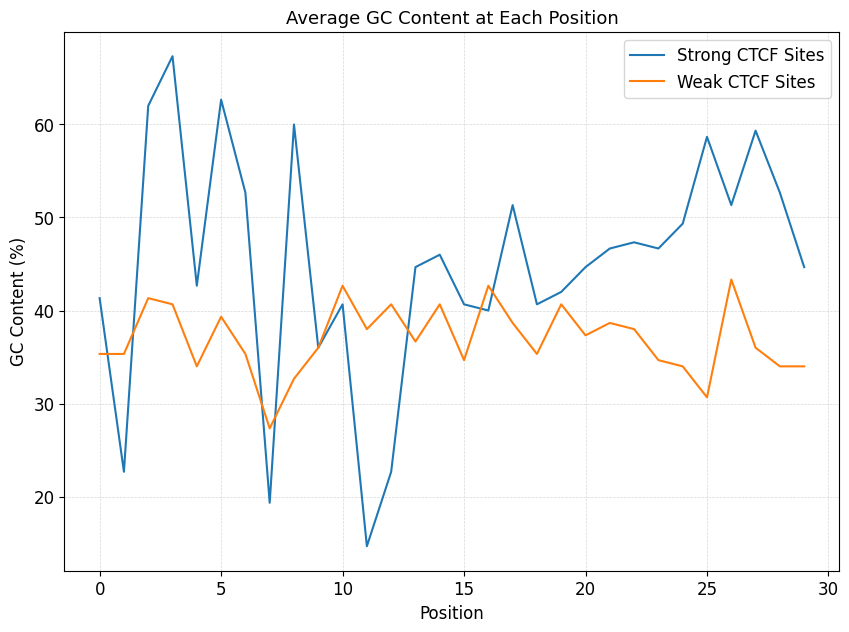

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(calculate_gc_content_at_positions(downstream_top), label='Strong CTCF Sites')
plt.plot(calculate_gc_content_at_positions(downstream_bottom), label='Weak CTCF Sites')
plt.xlabel('Position')
plt.ylabel('GC Content (%)')
plt.title('Average GC Content at Each Position')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [6]:
k = 3

In [7]:
# Define sequences
sequences = {
    "whole_top": whole_top,
    "upstream_top": upstream_top,
    "downstream_top": downstream_top,
    "whole_bottom": whole_bottom,
    "upstream_bottom": upstream_bottom,
    "downstream_bottom": downstream_bottom
}

# # Process sequences and apply PCA
# pca_results_k2 = process_sequences(sequences, k=k)

# # Access PCA results
# whole_top_pca_result_k2 = pca_results_k2["whole_top"]
# upstream_top_pca_result_k2 = pca_results_k2["upstream_top"]
# downstream_top_pca_result_k2 = pca_results_k2["downstream_top"]
# whole_bottom_pca_result_k2 = pca_results_k2["whole_bottom"]
# upstream_bottom_pca_result_k2 = pca_results_k2["upstream_bottom"]
# downstream_bottom_pca_result_k2 = pca_results_k2["downstream_bottom"]

In [8]:
# strong = upstream_top
# weak = upstream_bottom

strong = downstream_top
weak = downstream_bottom

In [ ]:
# kmer_counts_strong = count_kmers_total(upstream_top, k=k)
# kmer_counts_weak = count_kmers_total(upstream_bottom, k=k)

In [9]:
from collections import defaultdict
import numpy as np
import random

def count_kmers_freqs(sequences, k):
    counts = defaultdict(int)
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i + k]
            counts[kmer] += 1
    total_kmers = sum(counts.values())
    return {kmer: count / total_kmers for kmer, count in counts.items()}

In [10]:
# Calculate observed frequencies
strong_freqs = count_kmers_freqs(strong, k)
weak_freqs = count_kmers_freqs(weak, k)
observed_differences = {
    kmer: strong_freqs.get(kmer, 0) - weak_freqs.get(kmer, 0)
    for kmer in set(strong_freqs) | set(weak_freqs)
}

In [11]:
# num_bootstrap = 1000
num_bootstrap = 10000
alpha = 0.05

In [12]:
# Generate bootstrap samples
null_distributions = {kmer: [] for kmer in observed_differences}
for _ in range(num_bootstrap):
    strong_sample = [random.choice(strong) for _ in range(len(strong))]
    weak_sample = [random.choice(weak) for _ in range(len(weak))]
    strong_freqs_boot = count_kmers_freqs(strong_sample, k)
    weak_freqs_boot = count_kmers_freqs(weak_sample, k)
    for kmer in observed_differences:
        boot_diff = strong_freqs_boot.get(kmer, 0) - weak_freqs_boot.get(kmer, 0)
        null_distributions[kmer].append(boot_diff)

In [13]:
confidence_intervals = {}
for kmer, diffs in null_distributions.items():
    lower_bound = np.percentile(diffs, alpha / 2 * 100)
    upper_bound = np.percentile(diffs, (1 - alpha / 2) * 100)
    confidence_intervals[kmer] = (lower_bound, upper_bound)

In [14]:
significant_kmers = {
    kmer: observed_differences[kmer]
    for kmer, (lower, upper) in confidence_intervals.items()
    if lower > 0 or upper < 0  # Exclude zero
}

In [15]:
significant_kmers_list = list(significant_kmers.keys())

In [16]:
significant_kmers

{'GCG': 0.0064285714285714285,
 'ACC': 0.010952380952380951,
 'CCG': 0.002857142857142857,
 'CAG': 0.007142857142857142,
 'TGT': -0.01380952380952381,
 'ATT': -0.014285714285714284,
 'CCC': 0.007857142857142858,
 'TTT': -0.022142857142857145,
 'CGC': 0.006190476190476191,
 'CGG': 0.0028571428571428567,
 'GCT': 0.008095238095238095,
 'AGC': 0.008095238095238096,
 'GGC': 0.007857142857142856,
 'GTG': -0.006904761904761905,
 'CCA': 0.01476190476190476,
 'GAT': -0.00880952380952381,
 'TGC': 0.005714285714285713,
 'CAC': 0.014523809523809522,
 'TAA': -0.006904761904761903,
 'TTC': -0.006904761904761907,
 'GTA': -0.007142857142857142,
 'ACG': 0.0028571428571428567,
 'TAT': -0.009285714285714284,
 'GCA': 0.006190476190476191,
 'CGT': 0.003333333333333333,
 'ATA': -0.006190476190476189,
 'TTA': -0.012380952380952381,
 'AGG': 0.006666666666666666,
 'AGA': -0.01142857142857143,
 'CTT': -0.01047619047619048}

In [ ]:
# significant_kmers_list

In [17]:
# Sorting k-mers by their differences
sorted_kmers = sorted(significant_kmers.items(), key=lambda x: x[1])

# Selecting the top 3 with the lowest and highest differences
lowest_kmers = sorted_kmers[:3]
highest_kmers = sorted_kmers[-3:]

In [18]:
lowest_kmers, highest_kmers

([('TTT', -0.022142857142857145),
  ('ATT', -0.014285714285714284),
  ('TGT', -0.01380952380952381)],
 [('ACC', 0.010952380952380951),
  ('CAC', 0.014523809523809522),
  ('CCA', 0.01476190476190476)])

In [19]:
extremes = lowest_kmers + highest_kmers

In [20]:
extremes = dict(extremes)

In [21]:
extremes.keys()

dict_keys(['TTT', 'ATT', 'TGT', 'ACC', 'CAC', 'CCA'])

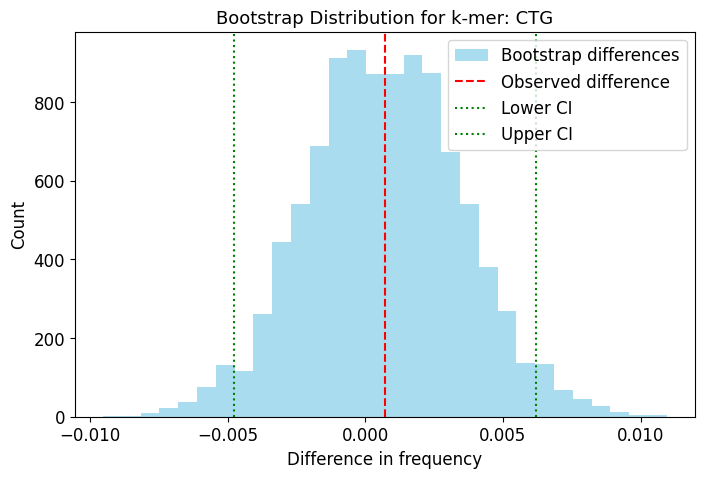

In [22]:
kmer_to_plot = list(null_distributions.keys())[-1]  # Choose a k-mer, e.g., the first one

plt.figure(figsize=(8, 5))
plt.hist(null_distributions[kmer_to_plot], bins=30, color="skyblue", alpha=0.7, label="Bootstrap differences")
plt.axvline(observed_differences[kmer_to_plot], color="red", linestyle="--", label="Observed difference")
plt.axvline(confidence_intervals[kmer_to_plot][0], color="green", linestyle=":", label="Lower CI")
plt.axvline(confidence_intervals[kmer_to_plot][1], color="green", linestyle=":", label="Upper CI")
plt.title(f"Bootstrap Distribution for k-mer: {kmer_to_plot}")
plt.xlabel("Difference in frequency")
plt.ylabel("Count")
plt.legend()
plt.show()

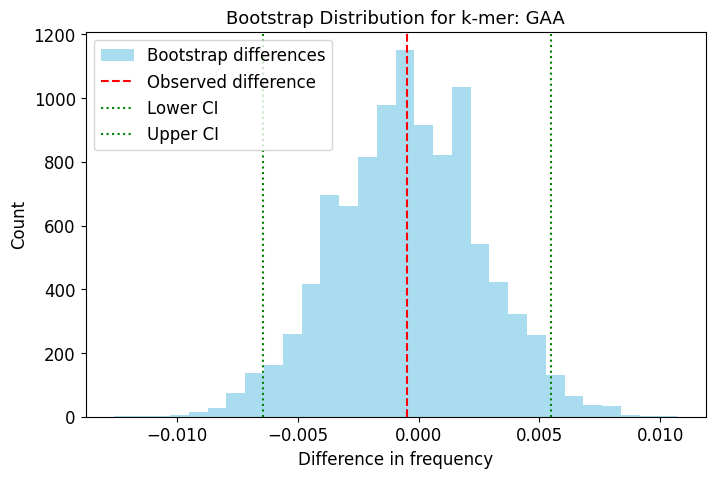

In [23]:
kmer_to_plot = list(null_distributions.keys())[-3]  # Choose a k-mer, e.g., the first one

plt.figure(figsize=(8, 5))
plt.hist(null_distributions[kmer_to_plot], bins=30, color="skyblue", alpha=0.7, label="Bootstrap differences")
plt.axvline(observed_differences[kmer_to_plot], color="red", linestyle="--", label="Observed difference")
plt.axvline(confidence_intervals[kmer_to_plot][0], color="green", linestyle=":", label="Lower CI")
plt.axvline(confidence_intervals[kmer_to_plot][1], color="green", linestyle=":", label="Upper CI")
plt.title(f"Bootstrap Distribution for k-mer: {kmer_to_plot}")
plt.xlabel("Difference in frequency")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
# sorted(observed_differences.keys())

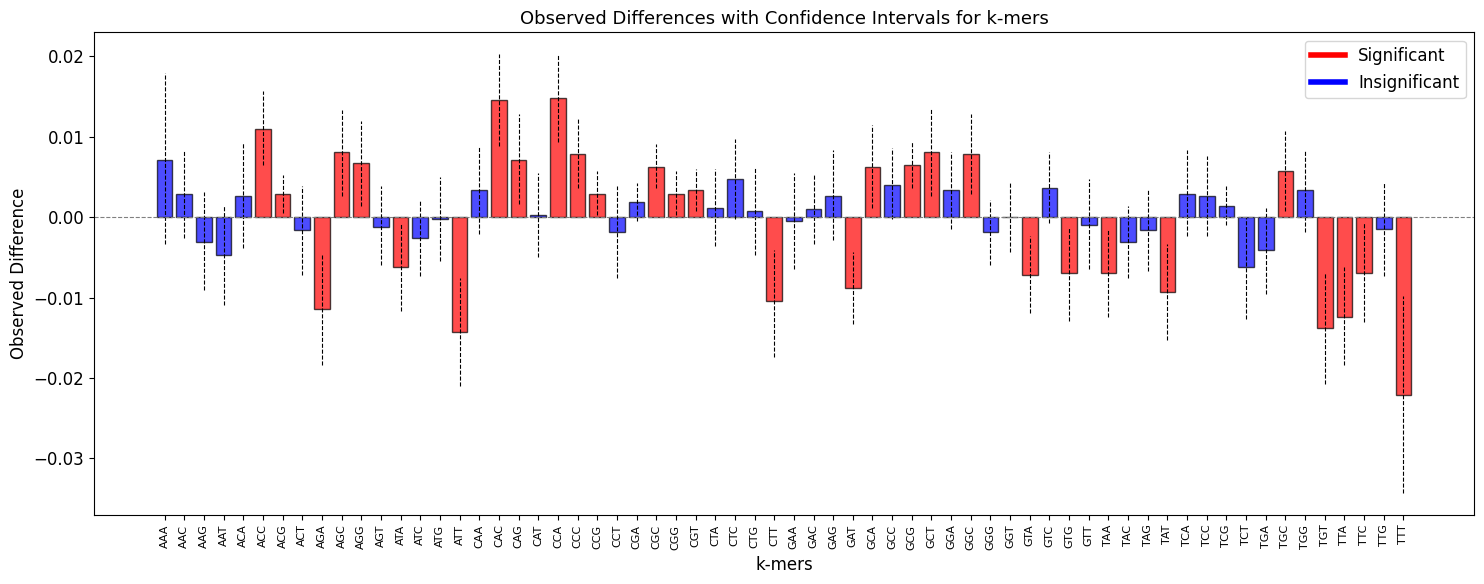

In [24]:
# # Sample 50 k-mers from observed_differences
# sampled_kmers = random.sample(list(observed_differences.keys()), 50)

# # Sort sampled k-mers
sorted_kmers = sorted(observed_differences.keys())

observed_values = [observed_differences[kmer] for kmer in sorted_kmers]
confidence_bounds = [confidence_intervals[kmer] for kmer in sorted_kmers]
colors = ["red" if kmer in significant_kmers else "blue" for kmer in sorted_kmers]

# Create the bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(sorted_kmers, observed_values, color=colors, alpha=0.7, edgecolor="black")

# Add confidence intervals
for i, (lower, upper) in enumerate(confidence_bounds):
    plt.plot([i, i], [lower, upper], color="black", linestyle="--", linewidth=0.8)

# Customize plot
plt.xticks(range(len(sorted_kmers)), sorted_kmers, rotation=90, fontsize=8)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Add a horizontal line at 0
plt.title("Observed Differences with Confidence Intervals for k-mers")
plt.xlabel("k-mers")
plt.ylabel("Observed Difference")
plt.legend(handles=[
    plt.Line2D([0], [0], color="red", lw=4, label="Significant"),
    plt.Line2D([0], [0], color="blue", lw=4, label="Insignificant")
])
plt.tight_layout()
plt.show()

In [ ]:
# plot

In [25]:
def count_kmers(sequences, k):
    counts = defaultdict(int)
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i + k]
            counts[kmer] += 1
    return {kmer: count for kmer, count in counts.items()}

In [26]:
kmer_counts_strong = count_kmers(strong, k=k)
kmer_counts_weak = count_kmers(weak, k=k)

In [27]:
# Convert Counter objects into dictionaries for consistent handling
def convert_counters_to_dict(strong_counts, weak_counts):
    all_kmers = set(strong_counts.keys()).union(weak_counts.keys())
    strong_freqs = {kmer: strong_counts.get(kmer, 0) for kmer in all_kmers}
    weak_freqs = {kmer: weak_counts.get(kmer, 0) for kmer in all_kmers}
    return strong_freqs, weak_freqs

In [28]:
strong_freqs, weak_freqs = convert_counters_to_dict(kmer_counts_strong, kmer_counts_weak)

In [29]:
kmers = sorted(strong_freqs.keys())
strong_values = [strong_freqs[kmer] for kmer in kmers]
weak_values = [weak_freqs[kmer] for kmer in kmers]

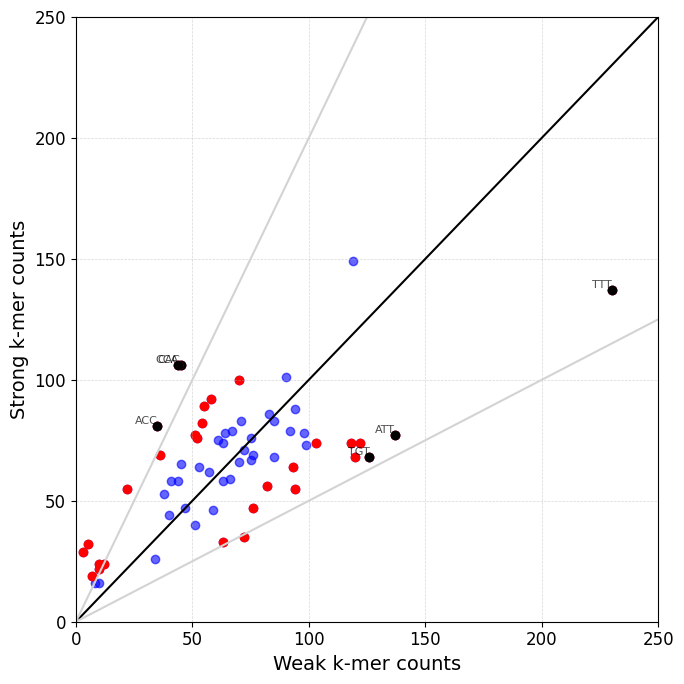

In [30]:
# Create scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(weak_values, strong_values, color='blue', alpha=0.6)

# Plot the diagonal line (x=y)
plt.plot([0, 250], [0, 250], linestyle='-', color='black')

# Add 2-fold up and down ratio lines
x_vals = np.linspace(0, 250, 10)
plt.plot(x_vals, 2 * x_vals, linestyle='-', color='lightgray')
plt.plot(x_vals, 0.5 * x_vals, linestyle='-', color='lightgray')

# Annotate each point with its kmer
for i, kmer in enumerate(kmers):
    if kmer in significant_kmers_list:
        plt.scatter(weak_values[i], strong_values[i], color='red', alpha=1.0)
        if kmer in extremes.keys():
            plt.text(
                weak_values[i], strong_values[i], ''.join(kmer), fontsize=8,
                ha='right', va='bottom', color='black', alpha=0.7
            )
            plt.scatter(weak_values[i], strong_values[i], color='black', alpha=1.0)
    # else:
    #     # if i % 2 == 1:
    #     plt.text(
    #         weak_values[i], strong_values[i], ''.join(kmer), fontsize=8,
    #         ha='right', va='bottom', color='black', alpha=0.7
    #     )

# Add labels and title
plt.xlabel('Weak k-mer counts', fontsize=14)
plt.ylabel('Strong k-mer counts', fontsize=14)

# plt.gca().set_aspect('equal', adjustable='box')

# Set limits to ensure both axes are 0-500
plt.xlim(0, 250)
plt.ylim(0, 250)

# plt.legend(loc='upper left', fontsize=10)

# Add grid and layout
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
# plt.savefig("./plots/downstream_k2.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
from itertools import product

In [ ]:
import random

In [ ]:
from collections import Counter

In [ ]:
# Function to calculate k-mer counts for a set of sequences
def calculate_kmer_counts(sequences, k=2):
    kmer_counts = Counter()
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            kmer_counts[kmer] += 1
    return kmer_counts

In [ ]:
k = 3
strong_counts = calculate_kmer_counts(downstream_top, k)
weak_counts = calculate_kmer_counts(downstream_bottom, k)

In [ ]:
strong_total = sum(strong_counts.values())
weak_total = sum(weak_counts.values())

strong_freqs = normalize_kmer_counts(strong_counts, strong_total)
weak_freqs = normalize_kmer_counts(weak_counts, weak_total)

observed_differences = {
    kmer: strong_freqs.get(kmer, 0) - weak_freqs.get(kmer, 0)
    for kmer in [''.join(kmer) for kmer in product("ACGT", repeat=3)]}

In [ ]:
print("Total strong counts:", sum(strong_counts.values()))
print("Total weak counts:", sum(weak_counts.values()))

In [ ]:
# observed_differences

In [ ]:
def generate_null_distribution(weak_seqs, strong_seqs, k, num_bootstraps):
    # Generate all possible k-mers as strings
    kmers = [''.join(kmer) for kmer in product("ACGT", repeat=k)]

    # Initialize null distribution as a dictionary of lists
    null_distributions = {kmer: [] for kmer in kmers}

    for _ in range(num_bootstraps):
        # Bootstrap samples
        weak_sample = np.random.choice(weak_seqs, size=len(weak_seqs), replace=True)
        strong_sample = np.random.choice(strong_seqs, size=len(strong_seqs), replace=True)

        # Count k-mers in bootstrap samples
        weak_counts = calculate_kmer_counts(weak_sample, k)
        strong_counts = calculate_kmer_counts(strong_sample, k)

        # Normalize k-mer frequencies
        weak_total = sum(weak_counts.values())
        strong_total = sum(strong_counts.values())

        weak_freqs = {kmer: weak_counts.get(kmer, 0) / weak_total for kmer in kmers}
        strong_freqs = {kmer: strong_counts.get(kmer, 0) / strong_total for kmer in kmers}

        # Calculate differences for this bootstrap
        for kmer in kmers:
            diff = strong_freqs.get(kmer, 0) - weak_freqs.get(kmer, 0)
            null_distributions[kmer].append(diff)

    return null_distributions

In [ ]:
# Generate null distribution by bootstrapping only from weak sequences
null_distributions = generate_null_distribution(upstream_bottom, upstream_top, k=k, num_bootstraps=1000)

In [ ]:
# null_distributions

In [ ]:
# Calculate p-values for each k-mer
p_values = {}
for kmer, obs_diff in observed_differences.items():
    null_dist = null_distributions[kmer]
    # Two-tailed p-value: Proportion of null differences >= |observed_difference|
    p_val = np.mean([1 if abs(x) >= abs(obs_diff) else 0 for x in null_dist])
    p_values[kmer] = p_val

# Example: View p-values for significant k-mers
significant_kmers = {kmer: p for kmer, p in p_values.items() if p < 0.05}
print("Significant k-mers:", significant_kmers)

In [ ]:
p_values

In [ ]:
import scipy.stats as stats

In [ ]:
print("kmer\tp-value")
for kmer, obs_diff in observed_differences.items():
    print(observed_differences[kmer], "\t", p_values[kmer])

In [ ]:
correlation, p_value = stats.pearsonr(np.abs(np.array(list(observed_differences.values()))), np.array(list(p_values.values())))

In [ ]:
correlation

In [ ]:
plt.scatter(np.abs(np.array(list(observed_differences.values()))), np.array(list(p_values.values())))
plt.xlabel("observed differences")
plt.ylabel("p-values")

In [ ]:
# Calculate p-values for each k-mer
p_values = {}
for kmer, obs_diff in observed_differences.items():
    null_dist = null_distributions[kmer]  # Null distribution for the k-mer
    # Two-tailed p-value calculation
    p_val = np.mean(np.abs(null_dist) >= np.abs(obs_diff))
    p_values[kmer] = p_val

# Example: View p-values
print("P-Values for each k-mer:")
for kmer, p_val in p_values.items():
    print(f"{kmer}: {p_val}")

In [ ]:
from scipy.stats import rankdata

p_values = {}
for kmer, obs_diff in observed_differences.items():
    null_dist = null_distributions[kmer]
    combined = np.abs(np.concatenate(([obs_diff], null_dist)))
    ranks = rankdata(combined, method='average')  # Rank the combined values
    obs_rank = ranks[0]  # The rank of the observed difference
    p_val = 1 - (obs_rank / len(combined))  # Compute the p-value
    p_values[kmer] = p_val

In [ ]:
print("P-Values for each k-mer:")
for kmer, p_val in p_values.items():
    print(f"{kmer}: {p_val}")

In [ ]:
plt.scatter(np.abs(np.array(list(observed_differences.values()))), np.array(list(p_values.values())))
plt.xlabel("observed differences")
plt.ylabel("p-values")

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

p_values = {}
for kmer, obs_diff in observed_differences.items():
    null_dist = null_distributions[kmer]
    ecdf = ECDF(np.abs(null_dist))  # Fit ECDF on absolute null distribution
    p_val = 1 - ecdf(np.abs(obs_diff))  # Tail probability
    p_values[kmer] = p_val

In [ ]:
plt.scatter(np.abs(np.array(list(observed_differences.values()))), np.array(list(p_values.values())))
plt.xlabel("observed differences")
plt.ylabel("p-values")

In [ ]:
p_values

In [ ]:
from scipy.stats import norm

In [ ]:
null_distributions

In [ ]:
def calculate_p_values_ztest(observed_differences, null_distributions):
    p_values = {}
    for kmer, obs_diff in observed_differences.items():
        null_dist = null_distributions[kmer]
        null_mean = np.mean(null_dist)
        null_std = np.std(null_dist)

        # Avoid division by zero
        if null_std == 0:
            p_values[kmer] = 1.0  # No variation in the null distribution
        else:
            # Z-score for the observed difference
            z_score = (obs_diff - null_mean) / null_std
            # Two-tailed p-value
            p_values[kmer] = 2 * norm.sf(abs(z_score))

    return p_values

In [ ]:
calculate_p_values_ztest(observed_differences, null_distributions)

In [ ]:
# Compare observed differences (strong vs weak) to null distribution
observed_differences, p_values = compare_kmer_differences(strong_seqs, weak_seqs, null_distributions, k=k)

# Print results
print("Observed Differences:", observed_differences)
print("P-values:", p_values)


In [ ]:
sum(kmer_counts_strong.values())

In [ ]:
kmer_counts_weak

In [ ]:
observed_counts_strong = dict(kmer_counts_strong)

In [ ]:
observed_counts_weak = dict(kmer_counts_weak)

In [ ]:
kmer_col = []
w_kmer_count = []
s_kmer_count = []

for im in total_counts_weak.items():
    w_kmer, w_count = im
    for it in total_counts_strong.items():
        s_kmer, s_count = it
        if w_kmer == s_kmer:
            kmer_col.append(s_kmer)
            w_kmer_count.append(w_count)
            s_kmer_count.append(s_count)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({"kmer": kmer_col, "weak_count": w_kmer_count, "strong_count": s_kmer_count})

In [ ]:
df["diff(s-w)"] = df["strong_count"] - df["weak_count"]

In [ ]:
df.sort_values(by="diff(s-w)", ascending=False)

In [ ]:
# converting GC percentage to probabilities
gc_strong = calculate_gc_content_at_positions(upstream_top) / 100
gc_weak = calculate_gc_content_at_positions(upstream_bottom) / 100

In [ ]:
# Total k-mers
sequence_length = 30
num_sequences = 150
kmer_size = 2
total_kmers = (sequence_length - kmer_size + 1) * num_sequences

In [ ]:
at_strong = 1 - gc_strong
at_weak = 1 - gc_weak

In [ ]:
def compute_kmer_probs(gc_content, at_content):
    # Compute base probabilities
    p_g = p_c = gc_content / 2
    p_a = p_t = at_content / 2

    # Compute k-mer probabilities (all 16 combinations)
    kmer_probs = {
        'AA': p_a * p_a,
        'AT': p_a * p_t,
        'TA': p_t * p_a,
        'TT': p_t * p_t,
        'GC': p_g * p_c,
        'CG': p_c * p_g,
        'AG': p_a * p_g,
        'GA': p_g * p_a,
        'CC': p_c * p_c,
        'CA': p_c * p_a,
        'TG': p_t * p_g,
        'GT': p_g * p_t,
        'AC': p_a * p_c,
        'CT': p_c * p_t,
        'GG': p_g * p_g,  # Adding GG k-mer
        'TC': p_t * p_c   # Adding TC k-mer
    }

    # Normalize probabilities to sum to 1
    total = sum(kmer_probs.values())
    for kmer in kmer_probs:
        kmer_probs[kmer] /= total

    return kmer_probs

In [ ]:
# Calculate expected k-mer probabilities for strong and weak sequences
kmer_probs_strong = compute_kmer_probs(gc_strong, at_strong)
kmer_probs_weak = compute_kmer_probs(gc_weak, at_weak)

In [ ]:
# Calculate expected k-mer counts by multiplying probabilities with total_kmers
expected_kmer_counts_strong = {kmer: np.mean(probs) * total_kmers for kmer, probs in kmer_probs_strong.items()}
expected_kmer_counts_weak = {kmer: np.mean(probs) * total_kmers for kmer, probs in kmer_probs_weak.items()}

In [ ]:
# Display results
print("Expected k-mer counts for strong sequences:")
for kmer, count in expected_kmer_counts_strong.items():
    print(f"{kmer}: {count:.2f}")

print("\nExpected k-mer counts for weak sequences:")
for kmer, count in expected_kmer_counts_weak.items():
    print(f"{kmer}: {count:.2f}")

In [ ]:
nucleotides = ['A', 'C', 'G', 'T']
kmer_list = [a + b for a in nucleotides for b in nucleotides]

In [ ]:
observed_strong = [observed_counts_strong.get(kmer, 0) for kmer in kmer_list]
observed_weak = [observed_counts_weak.get(kmer, 0) for kmer in kmer_list]
expected_strong = [expected_kmer_counts_strong.get(kmer, 0) for kmer in kmer_list]
expected_weak = [expected_kmer_counts_weak.get(kmer, 0) for kmer in kmer_list]

In [ ]:
observed_counts_strong

In [ ]:
sum(expected_kmer_counts_strong.values()), sum(observed_counts_strong.values())

In [ ]:
from scipy.stats import chisquare

In [ ]:
# Check the sum of observed and expected counts
sum_observed_strong = sum(observed_strong)
sum_expected_strong = sum(expected_strong)

print(f"Sum of observed counts: {sum_observed_strong}")
print(f"Sum of expected counts: {sum_expected_strong}")

In [ ]:
# Chi-squared test for strong sequences
chi2_strong, p_value_strong = chisquare(observed_strong, expected_strong)
print(f"Chi-squared test for strong sequences: chi2 = {chi2_strong}, p-value = {p_value_strong}")


In [ ]:
# Chi-squared test for weak sequences
chi2_weak, p_value_weak = chisquare(observed_weak, expected_weak)
print(f"Chi-squared test for weak sequences: chi2 = {chi2_weak}, p-value = {p_value_weak}")

In [ ]:
sorted_kmers = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)

In [ ]:
print("Sorted K-mer Counts:")
for kmer, count in sorted_kmers[:20]:
    print(f"{kmer}: {count}")

## PCA, 2-mers count, Core + 30bp Flanks

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(whole_top_pca_result_k2[:, 0], whole_top_pca_result_k2[:, 1], label="Strong CTCF Sites", alpha=0.6, edgecolors='w')
plt.scatter(whole_bottom_pca_result_k2[:, 0], whole_bottom_pca_result_k2[:, 1], label="Weak CTCF Sites", alpha=0.6, edgecolors='w')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 2-mer Counts, Core + 30bp Flanks')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
# plt.savefig("./plots/2mer_analysis_strong_vs_weak.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Scatter plot for strong CTCF sites
plt.figure(figsize=(10, 7))
plt.scatter(whole_top_pca_result_k2[:, 0], whole_top_pca_result_k2[:, 1], label="Strong CTCF Sites", alpha=0.6, edgecolors='w')
plt.scatter(whole_bottom_pca_result_k2[:, 0], whole_bottom_pca_result_k2[:, 1], label="Weak CTCF Sites", alpha=0.6, edgecolors='w')

# Annotate each point with the corresponding k-mer
for i, kmer in enumerate(kmer_list):  # assuming kmer_list corresponds to each sequence
    plt.annotate(kmer, (whole_top_pca_result_k2[i, 0], whole_top_pca_result_k2[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 2-mer Counts, Core + 30bp Flanks')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
# plt.savefig("./plots/2mer_analysis_strong_vs_weak.pdf", format="pdf", bbox_inches="tight")
plt.show()

## PCA, 2-mers count, Upstream Flank

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(upstream_top_pca_result_k2[:, 0], upstream_top_pca_result_k2[:, 1], label="Strong CTCF Sites", alpha=0.6, edgecolors='w')
plt.scatter(upstream_bottom_pca_result_k2[:, 0], upstream_bottom_pca_result_k2[:, 1], label="Weak CTCF Sites", alpha=0.6, edgecolors='w')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 2-mer Counts, Upstream Flank')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [ ]:
# Scatter plot for upstream CTCF sites
plt.figure(figsize=(10, 7))
plt.scatter(upstream_top_pca_result_k2[:, 0], upstream_top_pca_result_k2[:, 1], label="Strong CTCF Sites", alpha=0.6, edgecolors='w')
plt.scatter(upstream_bottom_pca_result_k2[:, 0], upstream_bottom_pca_result_k2[:, 1], label="Weak CTCF Sites", alpha=0.6, edgecolors='w')

# Annotate each point with the corresponding k-mer
for i, kmer in enumerate(kmer_list):  # assuming kmer_list_upstream_top corresponds to each sequence in upstream_top_pca_result_k2
    plt.annotate(kmer, (upstream_top_pca_result_k2[i, 0], upstream_top_pca_result_k2[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 2-mer Counts, Upstream Flank')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

## PCA, 2-mers count, Downstream Flank

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(downstream_top_pca_result_k2[:, 0], downstream_top_pca_result_k2[:, 1], label="Strong CTCF Sites", alpha=0.6, edgecolors='w')
plt.scatter(downstream_bottom_pca_result_k2[:, 0], downstream_bottom_pca_result_k2[:, 1], label="Weak CTCF Sites", alpha=0.6, edgecolors='w')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 2-mer Counts, Upstream Flank')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [ ]:
# Define sequences
sequences = {
    "whole_top": whole_top,
    "upstream_top": upstream_top,
    "downstream_top": downstream_top,
    "whole_bottom": whole_bottom,
    "upstream_bottom": upstream_bottom,
    "downstream_bottom": downstream_bottom
}

# Process sequences and apply PCA
pca_results_k2 = process_sequences(sequences, k=k)

# Access PCA results
whole_top_pca_result_k2 = pca_results_k2["whole_top"]
upstream_top_pca_result_k2 = pca_results_k2["upstream_top"]
downstream_top_pca_result_k2 = pca_results_k2["downstream_top"]
whole_bottom_pca_result_k2 = pca_results_k2["whole_bottom"]
upstream_bottom_pca_result_k2 = pca_results_k2["upstream_bottom"]
downstream_bottom_pca_result_k2 = pca_results_k2["downstream_bottom"]

In [ ]:
new_pca_results_k2 = process_sequences({"up": sequences["upstream_top"] + sequences["upstream_bottom"]}, k=k)

In [ ]:
len(new_pca_results_k2["up"][:150])

In [ ]:
# new_pca_results_k2["up"][-150:][:,0]

In [ ]:
# Scatter plot for upstream CTCF sites
plt.figure(figsize=(10, 7))
plt.scatter(new_pca_results_k2["up"][:150][:,0], new_pca_results_k2["up"][:150][:,1], label="Strong CTCF Sites", alpha=0.6, edgecolors='w')
plt.scatter(new_pca_results_k2["up"][-150:][:,0], new_pca_results_k2["up"][-150:][:,1], label="Weak CTCF Sites", alpha=0.6, edgecolors='w')

# Annotate each point with the corresponding k-mer
for i, kmer in enumerate(kmer_list):  # assuming kmer_list_upstream_top corresponds to each sequence in upstream_top_pca_result_k2
    plt.annotate(kmer, (new_pca_results_k2["up"][i, 0], new_pca_results_k2["up"][i, 1]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 2-mer Counts, Upstream Flank')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()